# Distinguish author-specific patterns in music

## Environment and data embedding

In [1]:
# EpyNN/nnlive/author_music/train.ipynb
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.rnn.models import RNN
from nnlibs.lstm.models import LSTM
from nnlibs.gru.models import GRU
from nnlibs.flatten.models import Flatten
from nnlibs.dropout.models import Dropout
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')
np.seterr(under='ignore')


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=196)

embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

## Feed-Forward (FF)

In [2]:
flatten = Flatten()

hidden_dense = Dense(64, relu)

dense = Dense(2, softmax)

layers = [embedding, flatten, hidden_dense, dense]

model = EpyNN(layers=layers, name='None')

In [3]:
model.initialize(loss='BCE', se_hPars=se_hPars, seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [4]:
model.train(epochs=20, init_logs=False)

+-------+----------+----------+-------+----------+--------+--------+-----------------+
| epoch |  lrate   |  lrate   |       | accuracy |        |  BCE   |   Experiment    |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)   |  (1)   |                 |
+-------+----------+----------+-------+----------+--------+--------+-----------------+
|   0   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|   2   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|   4   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|   6   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|   8   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|  10   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|  12   | 1.00e-01 | 1.00e-01 | 0.565 |  0.492   | 10.019 | 11.690 | 1628548943_None |
|  14   | 1.00e-01 | 1.00e-01 | 0.565 |  0.

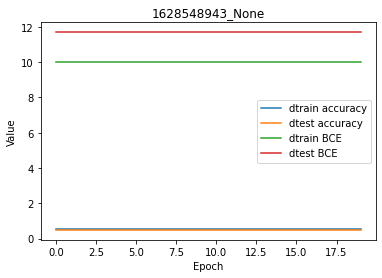

In [5]:
model.plot(path=False)

## Recurrent Neural Network (RNN)

In [6]:
se_hPars['learning_rate'] = 0.01
se_hPars['schedule'] = 'exp_decay'
se_hPars['decay_k'] = 0.01

rnn = RNN(220, sequences=False)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, rnn, flatten, dense]

model = EpyNN(layers=layers, name='None')

In [7]:
model.initialize(loss='BCE', se_hPars=se_hPars)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


In [8]:
model.train(epochs=20, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-----------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  BCE  |   Experiment    |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                 |
+-------+----------+----------+-------+----------+-------+-------+-----------------+
|   0   | 1.00e-02 | 1.00e-02 | 0.557 |  0.508   | 1.343 | 1.831 | 1628548944_None |
|   2   | 9.80e-03 | 9.80e-03 | 0.565 |  0.523   | 1.183 | 1.705 | 1628548944_None |
|   4   | 9.61e-03 | 9.61e-03 | 0.588 |  0.523   | 1.046 | 1.601 | 1628548944_None |
|   6   | 9.42e-03 | 9.42e-03 | 0.573 |  0.492   | 0.936 | 1.506 | 1628548944_None |
|   8   | 9.23e-03 | 9.23e-03 | 0.588 |  0.492   | 0.854 | 1.410 | 1628548944_None |
|  10   | 9.05e-03 | 9.05e-03 | 0.588 |  0.477   | 0.797 | 1.312 | 1628548944_None |
|  12   | 8.87e-03 | 8.87e-03 | 0.611 |  0.508   | 0.757 | 1.206 | 1628548944_None |
|  14   | 8.69e-03 | 8.69e-03 | 0.611 |  0.523   | 0.729 | 1.155 